# Segmentation (SegNet by Keras) for gyoza image

## Prepare training data
**TODO：学習するとき、fit_generatorを使うように改変（現状読み込み遅い）**

### Load data

In [55]:
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
from io import StringIO, BytesIO
import os
import pickle
import google.datalab.storage as storage
from google.datalab import Context
import random, string

In [56]:
# settings
cols = 224
rows = 224
channels = 3

In [57]:
project = Context.default().project_id
project

'kagglebu'

In [58]:
kagglebu_bucket = storage.Bucket('kagglebu')

In [59]:
kagglebu_bucket.exists()

True

An example of reading gyoza image 

In [60]:
sample_object = kagglebu_bucket.object('user/akihisa/gyoza/gyoza.png')
sample_object

Google Cloud Storage Object gs://kagglebu/user/akihisa/gyoza/gyoza.png

In [53]:
img = Image.open(BytesIO(sample_object.read_stream()), 'r')

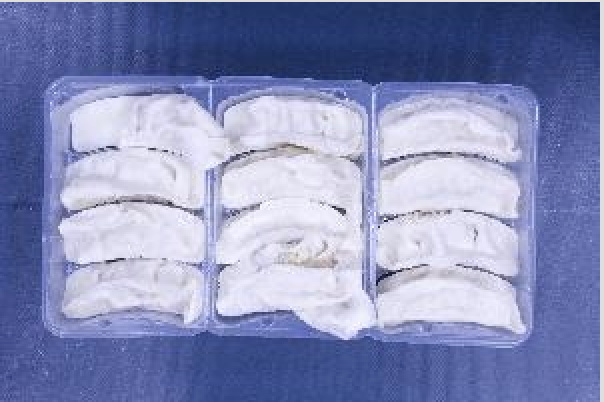

In [54]:
img

#### Read train images

In [72]:
input_objects = kagglebu_bucket.objects('user/akihisa/gyoza/segmentation/input_imgs/')
label_objects = kagglebu_bucket.objects('user/akihisa/gyoza/segmentation/labels/')

In [74]:
import sys

np_inputs = np.array([])
for idx, obj in enumerate(list(input_objects)[1:]): # list(input_objects)[0] is ignored because it's a directory, not an image path
  np_inputs_tmp = np.asarray(Image.open(BytesIO(obj.read_stream()), 'r'))
  if idx == 0:
    np_inputs = np_inputs_tmp[np.newaxis,:,:,:]
  else:
    np_inputs = np.concatenate((np_inputs, np_inputs_tmp[np.newaxis,:,:,:]), axis=0)
  sys.stdout.write("\r idx %s proceeds" % str(idx))
  sys.stdout.flush

 idx 3668 proceeds

In [ ]:
import sys

np_labels = np.array([])
for idx, obj in enumerate(list(label_objects)[1:]):
  np_labels_tmp = np.asarray(Image.open(BytesIO(obj.read_stream()), 'r'))
  if idx == 0:
    np_labels = np_labels_tmp[np.newaxis,:,:,:]
  elif np_labels_tmp.shape[2] == 4: # with alpha channel
    np_labels = np.concatenate((np_labels, np.array(Image.fromarray(np_labels_tmp).convert("RGB"))[np.newaxis,:,:,:]), axis=0)
  else:
    np_labels = np.concatenate((np_labels, np_labels_tmp[np.newaxis,:,:,:]), axis=0)
  sys.stdout.write("\r idx %s proceeds" % str(idx))
  sys.stdout.flush

 idx 3668 proceeds

'from PIL import Image \nnp_labels = np.array([np.array(Image.fromarray(np.asarray(Image.open(BytesIO(obj.read_stream()), \'r\'))).convert("RGB"))[np.newaxis,:,:,:] \n                   if np.asarray(Image.open(BytesIO(obj.read_stream()), \'r\')).shape[2] == 4 \n                   else np.asarray(Image.open(BytesIO(obj.read_stream()), \'r\'))[np.newaxis,:,:,:] \n                   for idx, obj in enumerate(list(label_objects)[1:])])'

In [93]:
print(len(np_inputs))
print(len(np_labels))

3669
3669


### Split data for training and evaluation

In [ ]:
# 省略

## Keras config

In [208]:
# CNN configuration
batch_size = 32 # batch_size = 64 provokes OOM error, so alternatively batch_size=32 is used  
epochs = 50 # 200

img_rows, img_cols, img_channels = rows, cols, channels

Branch processing whether Therano or TensorFlow is used as a backend

In [103]:
# from tensorflow.contrib.keras.python.keras import backend as K
from tensorflow.contrib.keras import backend as K

if K.image_data_format() == 'channels_first':
    np_inputs = np_inputs.reshape(np_inputs.shape[0], img_channels, img_rows, img_cols)
    #x_eval_reshaped = x_eval_reshaped.reshape(x_eval.shape[0], img_channels, img_rows, img_cols)
    
    input_shape = (img_channels, img_rows, img_cols)
else:
    np_inputs = np_inputs.reshape(np_inputs.shape[0], img_rows, img_cols, img_channels)
    #x_eval_reshaped = x_eval_reshaped.reshape(x_eval.shape[0], img_rows, img_cols, img_channels)
    
    input_shape = (img_rows, img_cols, img_channels)

print(input_shape)

(224, 224, 3)


In [104]:
# cast img_array for keras default setting(np.float32)
np_inputs = np_inputs.astype('float32') 
#x_eval_reshaped = x_eval_reshaped.astype('float32')

### Set Keras SegNet

#### pixel value experiment

In [152]:
test = np_labels[0][:,:,0] - np_labels[0][:,:,1] # borderと内部領域の画素値を確かめる

In [154]:
test[101,:]

array([  0,   0,   0, 255, 255, 255, 255,  46,  46,  46,  46,  46,  46,
        46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,
        46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,
        46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,
        46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46, 255,
       255, 255,   0,   0,   0,   0,   0,   0,   0,   0, 255, 255, 255,
       255,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,
        46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,
        46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,
        46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,
        46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46, 255,
       255, 255, 255, 255,   0,   0,   0,   0,   0,   0, 255, 255, 255,
       255,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,
        46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  4

#### Make labels

In [158]:
# (old) Methods of label creation (as 1 class)
"""def create_label(img):
  np_label_img = img[:,:,0]
  np_label_img.flags.writeable = True
  #print(np_label_img.flags)
  
  is_color = np_label_img >= 209
  isnt_color = np_label_img < 209 
  np_label_img[is_color] = 0
  np_label_img[isnt_color] = 1
  #print(np_label_img)
  y = np.zeros((1,224,224))
  
  for i in range(224):
    for j in range(224):
      if np_label_img[i,j] == 0:
        y[0,i,j] = 0
      else:
        y[0,i,j] = 1

  return y.astype('float32')"""

# As two class
def create_label(np_label):
  """label image array -> binarized label array (rows x cols x classes)"""
  classes = 2
  border = 255
  inner = 46
  y = np.zeros((224,224, classes))
  y_labeled_tmp = labeling(y, np_label, 0, border)
  y_labeled = labeling(y_labeled_tmp, np_label, 1, inner)
  return y_labeled.astype('float32')

def labeling(y, np_label, class_idx, thresh):
  """label image array, class index, pixel value of border or inner -> binarized label array"""
  np_label_2d = np_label[:,:,0] - np_label[:,:,1]
  np_label_2d.flags.writeable = True
  
  is_color = np_label_2d == thresh
  isnt_color = np_label_2d != thresh
  np_label_2d[is_color] = 1
  np_label_2d[isnt_color] = 0
  #print(np_label_2d)
  
  for i in range(224):
    for j in range(224):
      if np_label_2d[i,j] == 0:
        y[i,j,class_idx] = 0
      else:
        y[i,j,class_idx] = 1  
  return y

In [159]:
import sys

for idx, label_img in enumerate(np_labels):
  y_tmp = create_label(label_img) # use above method 
  if idx == 0:
    y = y_tmp[np.newaxis,:,:,:]
  else:
    y = np.concatenate((y, y_tmp[np.newaxis,:,:,:]), axis=0)
    
  sys.stdout.write("\r %s of %s proceeds" % (str(idx+1), str(len(np_labels))))
  sys.stdout.flush

 3669 of 3669 proceeds

#### Modeling

In [209]:
# Using API r1.5
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras._impl.keras.layers import merge
from tensorflow.python.keras.layers import Flatten, Dense, Dropout, Input, Activation, Reshape
from tensorflow.python.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Conv2D, UpSampling2D
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.optimizers import SGD
#from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras import backend as K
from tensorflow.python import keras

#K.set_image_dim_ordering('th')

def SegNet(input_shape=(224, 224, 3), classes=1):
    ### @ https://github.com/alexgkendall/SegNet-Tutorial/blob/master/Example_Models/bayesian_segnet_camvid.prototxt
    img_input = Input(shape=input_shape)
    x = img_input
    # Encoder
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(256, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(512, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Decoder
    x = Conv2D(512, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(classes, (1, 1), padding="valid")(x)
    x = Reshape((input_shape[0] * input_shape[1], classes))(x)
    x = Activation("sigmoid")(x)
    model = Model(img_input, x)
    return model

In [210]:
def reshape_labels(y):
  return np.reshape(y, (len(y), 224*224, 2))

In [211]:
model = SegNet(input_shape=(224, 224, 3), classes=2)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_17 (Batc (None, 224, 224, 64)      256       
_________________________________________________________________
activation_19 (Activation)   (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_18 (Batc (None, 112, 112, 128)     512       
__________

In [212]:
model.compile(loss="binary_crossentropy", optimizer='adadelta', metrics=["accuracy"])

In [86]:
#log_filepath='./logs/'
#tb_cb = keras.callbacks.TensorBoard(log_dir=log_filepath, histogram_freq=1, write_graph=True, write_images=True)

In [93]:
del input_imgs
del label_imgs

In [213]:
model.fit(np_inputs, reshape_labels(y.astype(bool)), batch_size=batch_size, epochs=epochs,
          verbose=1, shuffle=True) # , class_weight=class_weighting , validation_data=(test_X, test_Y), callbacks=[tb_cb]

Epoch 1/50
3669/3669 [==============================] - 49s - loss: 0.2909 - acc: 0.8927    
Epoch 2/50
3669/3669 [==============================] - 48s - loss: 0.1568 - acc: 0.9468    
Epoch 3/50
3669/3669 [==============================] - 48s - loss: 0.1160 - acc: 0.9576    
Epoch 4/50
3669/3669 [==============================] - 48s - loss: 0.0944 - acc: 0.9634    
Epoch 5/50
3669/3669 [==============================] - 48s - loss: 0.0786 - acc: 0.9686    
Epoch 6/50
3669/3669 [==============================] - 48s - loss: 0.0692 - acc: 0.9721    
Epoch 7/50
3669/3669 [==============================] - 48s - loss: 0.0623 - acc: 0.9749    
Epoch 8/50
3669/3669 [==============================] - 48s - loss: 0.0552 - acc: 0.9778    
Epoch 9/50
3669/3669 [==============================] - 48s - loss: 0.0504 - acc: 0.9798    
Epoch 10/50
3669/3669 [==============================] - 48s - loss: 0.0460 - acc: 0.9818    
Epoch 11/50
3669/3669 [==============================] - 48s - loss: 

#### Save model

In [214]:
model.save("seg_class2_50.h5")

In [215]:
""" TensorFlowのioモジュールを使えばgcsへの保存は難しくない
ローカルに一度保存 -> gcsへエクスポート　という流れ
"""

import tensorflow as tf
from tensorflow.python.lib.io import file_io

with file_io.FileIO('seg_class2_50.h5', mode='r') as input_f:
  with file_io.FileIO('gs://kagglebu/user/akihisa/gyoza/segmentation/seg_class2_50.h5', mode='w+') as output_f:
    output_f.write(input_f.read())
    print("Saved model.h5 to GCS")

Saved model.h5 to GCS


#### Load model

In [20]:
import tensorflow as tf
from tensorflow.python.lib.io import file_io

file_stream = file_io.FileIO('gs://kagglebu/user/akihisa/gyoza/segmentation/seg_class2_50.h5', mode='r+') # gs://経由は 'r+'

with file_io.FileIO('./seg_class2_50.h5', mode='w') as output_f:
  output_f.write(file_stream.read())
  print("Saved model.h5 in local")

Saved model.h5 in local


In [21]:
from tensorflow.python.keras.models import load_model
model = load_model('seg_class2_50.h5') #from local directory

## Prediction

### Load test data

In [2]:
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
from io import StringIO, BytesIO
import os
import pickle
import google.datalab.storage as storage
from google.datalab import Context
import random, string

In [3]:
project = Context.default().project_id
kagglebu_bucket = storage.Bucket('kagglebu')

In [33]:
#test_input_objects = kagglebu_bucket.objects('user/akihisa/gyoza/segmentation/test_data/')
test_input_objects = kagglebu_bucket.objects('user/akihisa/gyoza/segmentation/test_input_only_ok/')

In [34]:
list(test_input_objects)

[Google Cloud Storage Object gs://kagglebu/user/akihisa/gyoza/segmentation/test_input_only_ok/,
 Google Cloud Storage Object gs://kagglebu/user/akihisa/gyoza/segmentation/test_input_only_ok/OK_2017-11-06-085454-0000.avi.000029.jpg,
 Google Cloud Storage Object gs://kagglebu/user/akihisa/gyoza/segmentation/test_input_only_ok/OK_2017-11-06-085454-0000.avi.000029_flip.jpg,
 Google Cloud Storage Object gs://kagglebu/user/akihisa/gyoza/segmentation/test_input_only_ok/OK_2017-11-06-085454-0000.avi.000029_mirror.jpg,
 Google Cloud Storage Object gs://kagglebu/user/akihisa/gyoza/segmentation/test_input_only_ok/OK_2017-11-06-085454-0000.avi.000036.jpg,
 Google Cloud Storage Object gs://kagglebu/user/akihisa/gyoza/segmentation/test_input_only_ok/OK_2017-11-06-085454-0000.avi.000036_flip.jpg,
 Google Cloud Storage Object gs://kagglebu/user/akihisa/gyoza/segmentation/test_input_only_ok/OK_2017-11-06-085454-0000.avi.000036_mirror.jpg,
 Google Cloud Storage Object gs://kagglebu/user/akihisa/gyoza/se

In [35]:
import sys

def get_np_tests(test_input_objects):
  np_tests = np.array([])
  for idx, obj in enumerate(list(test_input_objects)[1:]):
    np_tests_tmp = np.asarray(Image.open(BytesIO(obj.read_stream()), 'r'))
    if idx == 0:
      np_tests = np_tests_tmp[np.newaxis,:,:,:]
    else:
      np_tests = np.concatenate((np_tests, np_tests_tmp[np.newaxis,:,:,:]), axis=0)
    sys.stdout.write("\r idx %s proceeds" % str(idx+1))
    sys.stdout.flush
  return np_tests
  
np_tests = get_np_tests(test_input_objects)

 idx 531 proceeds

In [36]:
np_tests.shape

(531, 224, 224, 3)

In [37]:
# from tensorflow.contrib.keras.python.keras import backend as K
from tensorflow.contrib.keras import backend as K

if K.image_data_format() == 'channels_first':
    np_tests = np_tests.reshape(np_tests.shape[0], np_tests.shape[3], np_tests.shape[1], np_tests.shape[2])
    input_shape = (np_labels.shape[3], np_labels.shape[1], np_labels.shape[2])
else:
    np_tests = np_tests.reshape(np_tests.shape[0], np_tests.shape[1], np_tests.shape[2], np_tests.shape[3])
    input_shape = (np_tests.shape[1], np_tests.shape[2], np_tests.shape[3])

print(input_shape)

# cast dtype of img_array for keras default setting(np.float32)
np_tests = np_tests.astype('float32') 

(224, 224, 3)


### Predict output labels

In [38]:
y_pred = model.predict(np_tests) 

Example <br>
(order: original -> flip -> mirror)

In [39]:
y_pred_eg = np.uint8(y_pred[2].reshape(224,224,2)*255)

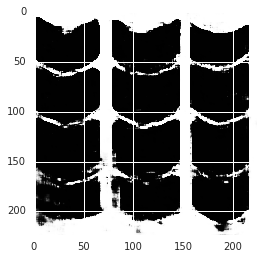

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(y_pred_eg[:,:,1])

### Save pred_imgs

In [41]:
# create filename list 
"""filenames = [str(test_input_object).replace('Google Cloud Storage Object gs://kagglebu/user/akihisa/gyoza/segmentation/test_data/', '')
             .replace('.png.jpg', '_pred_2class') for test_input_object in list(test_input_objects)[1:]]"""

filenames = [str(test_input_object).replace('Google Cloud Storage Object gs://kagglebu/user/akihisa/gyoza/segmentation/test_input_only_ok/', '')
             .replace('.jpg', '_pred_2class') for test_input_object in list(test_input_objects)[1:]]

In [45]:
# to local (temporary)
for idx, y_pred_elem in enumerate(y_pred):
  tmp_img_all = np.uint8(y_pred_elem.reshape(224,224,2)*255)
  tmp_img_border = Image.fromarray(tmp_img_all[:,:,0])
  tmp_img_inner = Image.fromarray(tmp_img_all[:,:,1])
  # tmp_img_border.save(filenames[idx]+"_border_50.png") 
  # tmp_img_inner.save(filenames[idx]+"_inner_50.png") 
  tmp_img_border.save("./test_pred_only_ok/"+filenames[idx]+"_border_50.png") 
  tmp_img_inner.save("./test_pred_only_ok/"+filenames[idx]+"_inner_50.png")   

In [226]:
"""# local to gcs
import sys
import tensorflow as tf
from tensorflow.python.lib.io import file_io

# save _border.png
for idx in range(len(y_pred)):
    with file_io.FileIO(filenames[idx]+"_border_50.png", mode='r') as input_f:
      with file_io.FileIO('gs://kagglebu/user/akihisa/gyoza/segmentation/pred_imgs/iter50/'+filenames[idx]+"_border.png", mode='w+') as output_f:
        output_f.write(input_f.read())
        sys.stdout.write("\r image idx %s saved" % str(idx+1))
        sys.stdout.flush
        
# save _inner.png
for idx in range(len(y_pred)):
    with file_io.FileIO(filenames[idx]+"_inner_50.png", mode='r') as input_f:
      with file_io.FileIO('gs://kagglebu/user/akihisa/gyoza/segmentation/pred_imgs/iter50/'+filenames[idx]+"_inner.png", mode='w+') as output_f:
        output_f.write(input_f.read())
        sys.stdout.write("\r image idx %s saved" % str(idx+1))
        sys.stdout.flush
"""

 image idx 139 saved

In [46]:
# local to gcs
import sys
import tensorflow as tf
from tensorflow.python.lib.io import file_io

# save _border.png
for idx in range(len(y_pred)):
    with file_io.FileIO("./test_pred_only_ok/"+filenames[idx]+"_border_50.png", mode='r') as input_f:
      with file_io.FileIO('gs://kagglebu/user/akihisa/gyoza/segmentation/pred_imgs/test_pred_only_ok/'+filenames[idx]+"_border.png", mode='w+') as output_f:
        output_f.write(input_f.read())
        sys.stdout.write("\r image idx %s saved" % str(idx+1))
        sys.stdout.flush
        
# save _inner.png
for idx in range(len(y_pred)):
    with file_io.FileIO("./test_pred_only_ok/"+filenames[idx]+"_inner_50.png", mode='r') as input_f:
      with file_io.FileIO('gs://kagglebu/user/akihisa/gyoza/segmentation/pred_imgs/test_pred_only_ok/'+filenames[idx]+"_inner.png", mode='w+') as output_f:
        output_f.write(input_f.read())
        sys.stdout.write("\r image idx %s saved" % str(idx+1))
        sys.stdout.flush

 image idx 531 saved

#### Save before-after compared imgs

余力があるとき作る

## Validation of border accuracy in occuluded area

### For Training data

#### Load overlapping gyoza images

In [4]:
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
from io import StringIO, BytesIO
import os
import pickle
import google.datalab.storage as storage
from google.datalab import Context
import random, string

In [5]:
project = Context.default().project_id
kagglebu_bucket = storage.Bucket('kagglebu')

In [6]:
test_input_objects = kagglebu_bucket.objects('user/akihisa/gyoza/segmentation/input_for_occulu/')

In [8]:
import sys

def get_np_tests(test_input_objects):
  np_tests = np.array([])
  for idx, obj in enumerate(list(test_input_objects)[1:]): # "list(test_input_objects)[0]" is a directory, so it's not included.
    np_tests_tmp = np.asarray(Image.open(BytesIO(obj.read_stream()), 'r'))
    if idx == 0:
      np_tests = np_tests_tmp[np.newaxis,:,:,:]
    else:
      np_tests = np.concatenate((np_tests, np_tests_tmp[np.newaxis,:,:,:]), axis=0)
    sys.stdout.write("\r idx %s proceeds" % str(idx))
    sys.stdout.flush
  return np_tests
  
np_tests = get_np_tests(test_input_objects)

 idx 6 proceeds

#### Prediction

In [10]:
# from tensorflow.contrib.keras.python.keras import backend as K
from tensorflow.contrib.keras import backend as K

if K.image_data_format() == 'channels_first':
    np_tests = np_tests.reshape(np_tests.shape[0], np_tests.shape[3], np_tests.shape[1], np_tests.shape[2])
    input_shape = (np_labels.shape[3], np_labels.shape[1], np_labels.shape[2])
else:
    np_tests = np_tests.reshape(np_tests.shape[0], np_tests.shape[1], np_tests.shape[2], np_tests.shape[3])
    input_shape = (np_tests.shape[1], np_tests.shape[2], np_tests.shape[3])

print(input_shape)

# cast img_array for keras default setting(np.float32)
np_tests = np_tests.astype('float32') 

(224, 224, 3)


In [ ]:
# Load pretrained model
from tensorflow.python.keras.models import load_model
model = load_model('seg_class2_50.h5') #from local directory

In [11]:
y_pred = model.predict(np_tests) 

In [27]:
y_pred_for_eval = y_pred.reshape(7, 224, 224, 2) # labelデータの形式に合わせる

#### Load true labels

In [14]:
true_label_objects = kagglebu_bucket.objects('user/akihisa/gyoza/segmentation/labals_for_occulu/')

In [17]:
import sys

def get_np_tests(true_label_objects):
  np_labels = np.array([])
  for idx, obj in enumerate(list(true_label_objects)[1:]): # list(test_input_objects)[0] is directory
    np_labels_tmp = np.asarray(Image.open(BytesIO(obj.read_stream()), 'r'))
    if idx == 0:
      np_labels = np_labels_tmp[np.newaxis,:,:,:]
    else:
      np_labels = np.concatenate((np_labels, np_labels_tmp[np.newaxis,:,:,:]), axis=0)
    sys.stdout.write("\r idx %s proceeds" % str(idx))
    sys.stdout.flush
  return np_labels
  
np_labels = get_np_tests(true_label_objects)

 idx 6 proceeds

#### Make True outputs

Method for making outputs

In [19]:
def create_label(np_label):
  classes = 2
  border = 255
  inner = 46
  y = np.zeros((224,224, classes))
  y_labeled_tmp = labeling(y, np_label, 0, border) 
  y_labeled = labeling(y_labeled_tmp, np_label, 1, inner) 
  return y_labeled.astype('float32')

def labeling(y, np_label, class_idx, thresh):
  np_label_2d = np_label[:,:,0] - np_label[:,:,1]
  np_label_2d.flags.writeable = True
  
  is_color = np_label_2d == thresh
  isnt_color = np_label_2d != thresh
  np_label_2d[is_color] = 1
  np_label_2d[isnt_color] = 0
  #print(np_label_2d)
  
  for i in range(224):
    for j in range(224):
      if np_label_2d[i,j] == 0:
        y[i,j,class_idx] = 0
      else:
        y[i,j,class_idx] = 1  
  return y

Make outputs

In [21]:
import sys
#y = np.array([])
for idx, label_img in enumerate(np_labels):
  y_tmp = create_label(label_img)
  if idx == 0:
    y_true = y_tmp[np.newaxis,:,:,:]
  else:
    y_true = np.concatenate((y_true, y_tmp[np.newaxis,:,:,:]), axis=0)
    
  sys.stdout.write("\r %s of %s proceeds" % (str(idx+1), str(len(np_labels))))
  sys.stdout.flush

 7 of 7 proceeds

#### Evaluation(calculate loss functions) by using sklearn

In [74]:
import numpy as np
from sklearn.metrics import log_loss

log_loss(y_true.reshape(702464,-1), y_pred_for_eval.reshape(702464,-1), eps=1e-7)

0.12119727066514056

In [75]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_true.reshape(y_true.shape[0], -1), y_pred_for_eval.reshape(y_pred_for_eval.shape[0], -1))

0.03744573

In [63]:
def rsmle(y_true, y_pred):
  """y_true,y_pred (2darray) -> remle score
  """
  return np.sqrt(np.mean(np.power(np.log(y_true+1)-np.log(y_pred+1), 2)))

In [65]:
rsmle(y_true.reshape(y_true.shape[0], -1), y_pred_for_eval.reshape(y_pred_for_eval.shape[0], -1))

0.13541287

In [90]:
y_pred_for_eval_eg = np.uint8(y_pred_for_eval[6].reshape(224,224,2)*255)

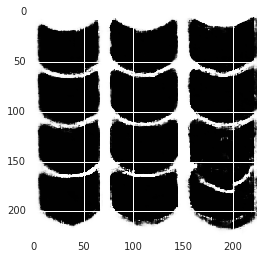

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(y_pred_for_eval_eg[:,:,1])

### For evaluation data

#### Processings of input data

In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import seaborn as sns
from io import StringIO, BytesIO
import os
import pickle
import google.datalab.storage as storage
from google.datalab import Context
import random, string

In [2]:
project = Context.default().project_id
kagglebu_bucket = storage.Bucket('kagglebu')

In [3]:
eval_input_objects = kagglebu_bucket.objects('user/akihisa/gyoza/segmentation/occulu_eval_input/')

In [47]:
import sys

def get_np_tests(test_input_objects):
  np_tests = np.array([])
  for idx, obj in enumerate(list(test_input_objects)):
    np_tests_tmp = np.asarray(Image.open(BytesIO(obj.read_stream()), 'r'))
    if idx == 0:
      np_tests = np_tests_tmp[np.newaxis,:,:,:]
    else:
      np_tests = np.concatenate((np_tests, np_tests_tmp[np.newaxis,:,:,:]), axis=0)
    sys.stdout.write("\r idx %s proceeds" % str(idx))
    sys.stdout.flush
  return np_tests
  
np_eval_inputs = get_np_tests(eval_input_objects)

 idx 19 proceeds

In [48]:
# from tensorflow.contrib.keras.python.keras import backend as K
from tensorflow.contrib.keras import backend as K

if K.image_data_format() == 'channels_first':
    np_eval_inputs = np_eval_inputs.reshape(np_eval_inputs.shape[0], np_eval_inputs.shape[3], np_eval_inputs.shape[1], np_eval_inputs.shape[2])
    input_shape = (np_eval_inputs.shape[3], np_eval_inputs.shape[1], np_eval_inputs.shape[2])
else:
    np_eval_inputs = np_eval_inputs.reshape(np_eval_inputs.shape[0], np_eval_inputs.shape[1], np_eval_inputs.shape[2], np_eval_inputs.shape[3])
    input_shape = (np_eval_inputs.shape[1], np_eval_inputs.shape[2], np_eval_inputs.shape[3])

print(input_shape)

# cast img_array for keras default setting(np.float32)
np_eval_inputs = np_eval_inputs.astype('float32') 

(224, 224, 3)


In [49]:
from tensorflow.python.keras.models import load_model
model = load_model('seg_class2_50.h5') #from local directory

In [50]:
y_pred = model.predict(np_eval_inputs) 

In [51]:
y_pred_for_eval = y_pred.reshape(-1, 224, 224, 2) # reshape predicted output array for label data shape

#### Processings of output data

In [52]:
eval_label_objects = kagglebu_bucket.objects('user/akihisa/gyoza/segmentation/occulu_eval_output/')

In [54]:
import sys

def get_np_tests(true_label_objects):
  np_labels = np.array([])
  for idx, obj in enumerate(list(true_label_objects)):
    np_labels_tmp = np.asarray(Image.open(BytesIO(obj.read_stream()), 'r'))
    if idx == 0:
      np_labels = np_labels_tmp[np.newaxis,:,:,:]
    else:
      np_labels = np.concatenate((np_labels, np_labels_tmp[np.newaxis,:,:,:]), axis=0)
    sys.stdout.write("\r idx %s proceeds" % str(idx))
    sys.stdout.flush
  return np_labels
  
np_eval_labels = get_np_tests(eval_label_objects)

 idx 19 proceeds

In [20]:
def create_label(np_label):
  classes = 2
  border = 255
  inner = 46
  y = np.zeros((224,224, classes))
  y_labeled_tmp = labeling(y, np_label, 0, border)
  y_labeled = labeling(y_labeled_tmp, np_label, 1, inner)
  return y_labeled.astype('float32')

def labeling(y, np_label, class_idx, thresh):
  np_label_2d = np_label[:,:,0] - np_label[:,:,1] # RGBのうちRの画素値で条件分岐 46:餃子内側領域, 255:
  np_label_2d.flags.writeable = True
  
  is_color = np_label_2d == thresh
  isnt_color = np_label_2d != thresh
  np_label_2d[is_color] = 1
  np_label_2d[isnt_color] = 0
  #print(np_label_2d)
  
  for i in range(224):
    for j in range(224):
      if np_label_2d[i,j] == 0:
        y[i,j,class_idx] = 0
      else:
        y[i,j,class_idx] = 1  
  return y

In [55]:
import sys
#y = np.array([])
for idx, label_img in enumerate(np_eval_labels):
  y_tmp = create_label(label_img)
  if idx == 0:
    y_true_eval = y_tmp[np.newaxis,:,:,:]
  else:
    y_true_eval = np.concatenate((y_true_eval, y_tmp[np.newaxis,:,:,:]), axis=0)
    
  sys.stdout.write("\r %s of %s proceeds" % (str(idx+1), str(len(np_eval_labels))))
  sys.stdout.flush

 20 of 20 proceeds

#### Evaluation

In [57]:
import numpy as np
from sklearn.metrics import log_loss

log_loss(y_true_eval.reshape(2007040,-1), y_pred_for_eval.reshape(2007040,-1), eps=1e-7)

0.706902224657388

In [58]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_true_eval.reshape(y_true_eval.shape[0], -1), y_pred_for_eval.reshape(y_pred_for_eval.shape[0], -1))

0.1218683

In [35]:
def rsmle(y_true, y_pred):
  """y_true,y_pred (2darray) -> remle score
  """
  return np.sqrt(np.mean(np.power(np.log(y_true+1)-np.log(y_pred+1), 2)))

In [59]:
rsmle(y_true_eval.reshape(y_true_eval.shape[0], -1), y_pred_for_eval.reshape(y_pred_for_eval.shape[0], -1))

0.24131869

visualization e.g.)

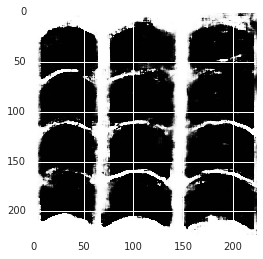

In [69]:
y_pred_for_eval_eg = np.uint8(y_pred_for_eval[9].reshape(224,224,2)*255)

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(y_pred_for_eval_eg[:,:,1])

[重複あり餃子に関する定量的評価]

考察：
- loglossが0.7　-> 正解率は約50%　(train data は 約88%)
    -当たらずも遠からず　という感じ -> 特徴を捉えているものも、いないものもある
- 画像を観察しても、境界を捉えていそうなものもあれば、そうでないものもあり
    - 重複（or 霜）がない領域は、境界がはっきりしている。
    - 重複領域の近傍は、境界がかなりぼやけている 

気になる点：
- 重複餃子のデータをあまり用意できなかったことが原因？ （重複のデータが多ければもう少し確率が上がる？）
- 入力ラベルを所々雑に作ったこともlossを増やしていそう
    
結論：
- 餃子とプレートの境界は高精度で分離可能
- 霜、餃子同士の重複がない場合は餃子の領域抽出は高精度で可能
- 霜、餃子同士の重複は、特徴を捉えられているものもありそう。改良次第では、これらの餃子の抽出の精度は上がる可能性あり。

#### Save predicted images for occuluded gyoza

In [76]:
# create filename list 
filenames = [str(eval_input_object).replace('Google Cloud Storage Object gs://kagglebu/user/akihisa/gyoza/segmentation/occulu_eval_input/', '')
             .replace('.png.jpg', '_pred_2class') for eval_input_object in list(eval_input_objects)]

In [78]:
# to local (temporary)
for idx, y_pred_elem in enumerate(y_pred):
  tmp_img_all = np.uint8(y_pred_elem.reshape(224,224,2)*255)
  tmp_img_border = Image.fromarray(tmp_img_all[:,:,0])
  tmp_img_inner = Image.fromarray(tmp_img_all[:,:,1])
  tmp_img_border.save(filenames[idx]+"_occulu_border_50.png") 
  tmp_img_inner.save(filenames[idx]+"_occulu_inner_50.png")

In [79]:
# local to gcs
import sys
import tensorflow as tf
from tensorflow.python.lib.io import file_io

# save _border.png
for idx in range(len(y_pred)):
    with file_io.FileIO(filenames[idx]+"_occulu_border_50.png", mode='r') as input_f:
      with file_io.FileIO('gs://kagglebu/user/akihisa/gyoza/segmentation/pred_occulu_imgs/'+filenames[idx]+"_border.png", mode='w+') as output_f:
        output_f.write(input_f.read())
        sys.stdout.write("\r image idx %s saved" % str(idx+1))
        sys.stdout.flush
        
# save _inner.png
for idx in range(len(y_pred)):
    with file_io.FileIO(filenames[idx]+"_occulu_inner_50.png", mode='r') as input_f:
      with file_io.FileIO('gs://kagglebu/user/akihisa/gyoza/segmentation/pred_occulu_imgs/'+filenames[idx]+"_inner.png", mode='w+') as output_f:
        output_f.write(input_f.read())
        sys.stdout.write("\r image idx %s saved" % str(idx+1))
        sys.stdout.flush

 image idx 20 saved